#### based on https://github.com/dipuk0506/SpinalNet

In [1]:
from __future__ import print_function, division

import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable
import random
import torch.nn.functional as F

exp_num = "28_auto_aug _eo_sar"


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     tf.set_random_seed(seed)

In [3]:
seed = 2019
seed_everything(seed)

## auto augment

In [4]:
## https://github.com/4uiiurz1/pytorch-auto-augment/blob/56e4ba03e4e914abe4e22db8d78c6407c0a21866/auto_augment.py#L251

import random
import numpy as np
import scipy
from scipy import ndimage
from PIL import Image, ImageEnhance, ImageOps


class AutoAugment(object):
    def __init__(self):
        self.policies = [
            ['Invert', 0.1, 7, 'Contrast', 0.2, 6],
            ['Rotate', 0.7, 2, 'TranslateX', 0.3, 9],
            ['Sharpness', 0.8, 1, 'Sharpness', 0.9, 3],
            ['ShearY', 0.5, 8, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.5, 8, 'Equalize', 0.9, 2],
            ['ShearY', 0.2, 7, 'Posterize', 0.3, 7],
            ['Color', 0.4, 3, 'Brightness', 0.6, 7],
            ['Sharpness', 0.3, 9, 'Brightness', 0.7, 9],
            ['Equalize', 0.6, 5, 'Equalize', 0.5, 1],
            ['Contrast', 0.6, 7, 'Sharpness', 0.6, 5],
            ['Color', 0.7, 7, 'TranslateX', 0.5, 8],
            ['Equalize', 0.3, 7, 'AutoContrast', 0.4, 8],
            ['TranslateY', 0.4, 3, 'Sharpness', 0.2, 6],
            ['Brightness', 0.9, 6, 'Color', 0.2, 8],
            ['Solarize', 0.5, 2, 'Invert', 0.0, 3],
            ['Equalize', 0.2, 0, 'AutoContrast', 0.6, 0],
            ['Equalize', 0.2, 8, 'Equalize', 0.6, 4],
            ['Color', 0.9, 9, 'Equalize', 0.6, 6],
            ['AutoContrast', 0.8, 4, 'Solarize', 0.2, 8],
            ['Brightness', 0.1, 3, 'Color', 0.7, 0],
            ['Solarize', 0.4, 5, 'AutoContrast', 0.9, 3],
            ['TranslateY', 0.9, 9, 'TranslateY', 0.7, 9],
            ['AutoContrast', 0.9, 2, 'Solarize', 0.8, 3],
            ['Equalize', 0.8, 8, 'Invert', 0.1, 3],
            ['TranslateY', 0.7, 9, 'AutoContrast', 0.9, 1],
        ]

    def __call__(self, img):
        img = apply_policy(img, self.policies[random.randrange(len(self.policies))])
        return img


operations = {
    'ShearX': lambda img, magnitude: shear_x(img, magnitude),
    'ShearY': lambda img, magnitude: shear_y(img, magnitude),
    'TranslateX': lambda img, magnitude: translate_x(img, magnitude),
    'TranslateY': lambda img, magnitude: translate_y(img, magnitude),
    'Rotate': lambda img, magnitude: rotate(img, magnitude),
    'AutoContrast': lambda img, magnitude: auto_contrast(img, magnitude),
    'Invert': lambda img, magnitude: invert(img, magnitude),
    'Equalize': lambda img, magnitude: equalize(img, magnitude),
    'Solarize': lambda img, magnitude: solarize(img, magnitude),
    'Posterize': lambda img, magnitude: posterize(img, magnitude),
    'Contrast': lambda img, magnitude: contrast(img, magnitude),
    'Color': lambda img, magnitude: color(img, magnitude),
    'Brightness': lambda img, magnitude: brightness(img, magnitude),
    'Sharpness': lambda img, magnitude: sharpness(img, magnitude),
    'Cutout': lambda img, magnitude: cutout(img, magnitude),
}


def apply_policy(img, policy):
    if random.random() < policy[1]:
        img = operations[policy[0]](img, policy[2])
    if random.random() < policy[4]:
        img = operations[policy[3]](img, policy[5])

    return img


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = offset_matrix @ matrix @ reset_matrix
    return transform_matrix


def shear_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def shear_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-0.3, 0.3, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]), 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_x(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, 0],
                                 [0, 1, img.shape[1]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def translate_y(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-150/331, 150/331, 11)

    transform_matrix = np.array([[1, 0, img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def rotate(img, magnitude):
    img = np.array(img)
    magnitudes = np.linspace(-30, 30, 11)
    theta = np.deg2rad(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    transform_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0],
                                 [0, 0, 1]])
    transform_matrix = transform_matrix_offset_center(transform_matrix, img.shape[0], img.shape[1])
    affine_matrix = transform_matrix[:2, :2]
    offset = transform_matrix[:2, 2]
    img = np.stack([ndimage.interpolation.affine_transform(
                    img[:, :, c],
                    affine_matrix,
                    offset) for c in range(img.shape[2])], axis=2)
    img = Image.fromarray(img)
    return img


def auto_contrast(img, magnitude):
    img = ImageOps.autocontrast(img)
    return img


def invert(img, magnitude):
    img = ImageOps.invert(img)
    return img


def equalize(img, magnitude):
    img = ImageOps.equalize(img)
    return img


def solarize(img, magnitude):
    magnitudes = np.linspace(0, 256, 11)
    img = ImageOps.solarize(img, random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def posterize(img, magnitude):
    magnitudes = np.linspace(4, 8, 11)
    img = ImageOps.posterize(img, int(round(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))))
    return img


def contrast(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Contrast(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def color(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Color(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def brightness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Brightness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def sharpness(img, magnitude):
    magnitudes = np.linspace(0.1, 1.9, 11)
    img = ImageEnhance.Sharpness(img).enhance(random.uniform(magnitudes[magnitude], magnitudes[magnitude+1]))
    return img


def cutout(org_img, magnitude=None):
    img = np.array(img)

    magnitudes = np.linspace(0, 60/331, 11)

    img = np.copy(org_img)
    mask_val = img.mean()

    if magnitude is None:
        mask_size = 16
    else:
        mask_size = int(round(img.shape[0]*random.uniform(magnitudes[magnitude], magnitudes[magnitude+1])))
    top = np.random.randint(0 - mask_size//2, img.shape[0] - mask_size)
    left = np.random.randint(0 - mask_size//2, img.shape[1] - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    if top < 0:
        top = 0
    if left < 0:
        left = 0

    img[top:bottom, left:right, :].fill(mask_val)

    img = Image.fromarray(img)

    return img



class Cutout(object):
    def __init__(self, length=16):
        self.length = length

    def __call__(self, img):
        img = np.array(img)

        mask_val = img.mean()

        top = np.random.randint(0 - self.length//2, img.shape[0] - self.length)
        left = np.random.randint(0 - self.length//2, img.shape[1] - self.length)
        bottom = top + self.length
        right = left + self.length

        top = 0 if top < 0 else top
        left = 0 if left < 0 else top

        img[top:bottom, left:right, :] = mask_val

        img = Image.fromarray(img)

        return img

In [5]:
alpha_ = 0.4


# def mixup_data(x, y, alpha=alpha_, use_cuda=True):
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     if use_cuda:
#         index = torch.randperm(batch_size).cuda()
#     else:
#         index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred.float().cuda(), y_a.float().cuda()) + (1 - lam) * criterion(pred.float().cuda(), y_b.float().cuda())


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

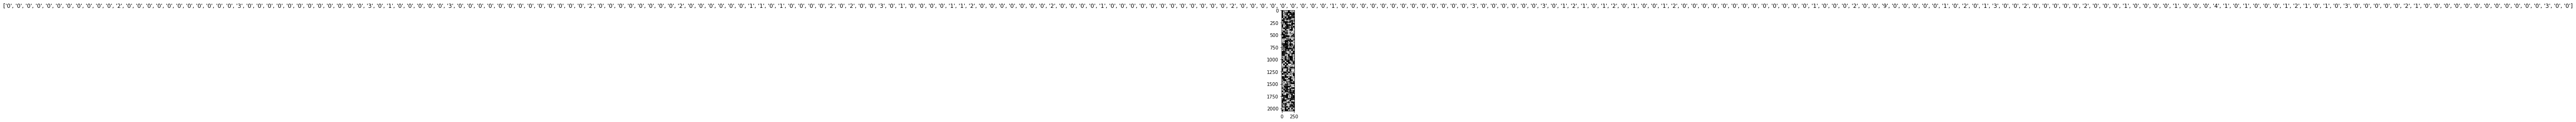

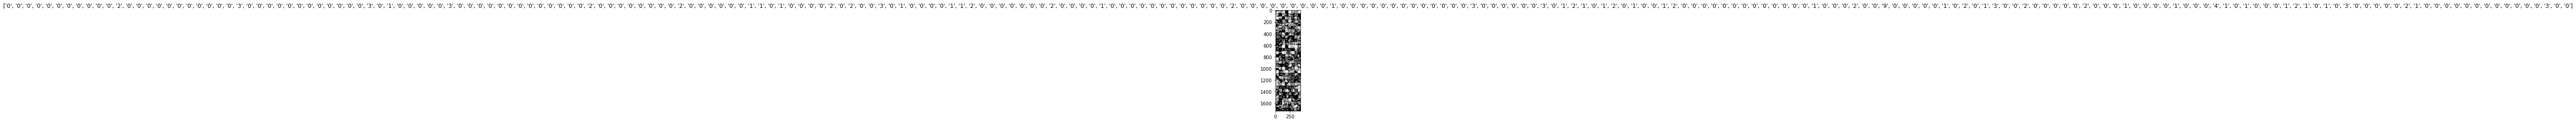

In [47]:




plt.ion()   # interactive mode

EO_data_transforms = {
    'training_EO': transforms.Compose([
        
        transforms.Resize((30,30)),
        AutoAugment(),
        Cutout(),
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(30),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
        
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test_EO': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(30),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid_EO': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((30,30)),
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(48),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.2913437], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}



# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(48),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        AutoAugment(),
        Cutout(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        #transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'Test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(52),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((52,52)),
#         transforms.RandomRotation(15,),
#         transforms.RandomResizedCrop(48),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4062625], [0.12694514])
        
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Resize(48),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5])
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
       # transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}



data_dir = '/mnt/sda1/cvpr21/Classification/ram'
EO_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          EO_data_transforms[x])
                  for x in ['training_EO', 'test_EO']}
EO_dataloaders = {x: torch.utils.data.DataLoader(EO_image_datasets[x], batch_size=512,
                                             shuffle=True, num_workers=64, pin_memory=True)
              for x in ['training_EO', 'test_EO']}
EO_dataset_sizes = {x: len(EO_image_datasets[x]) for x in ['training_EO', 'test_EO']}
EO_class_names = EO_image_datasets['training_EO'].classes



image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=64, pin_memory=True)
              for x in ['Training', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Test']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.1786, 0.4739, 0.5329])
#     std = np.array([[0.0632, 0.1361, 0.0606]])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


    
# Get a batch of training data
EO_inputs, EO_classes = next(iter(EO_dataloaders['training_EO']))


inputs, classes = next(iter(dataloaders['Training']))






# Make a grid from batch
EO_out = torchvision.utils.make_grid(EO_inputs)

out = torchvision.utils.make_grid(inputs)
imshow(EO_out, title=[EO_class_names[x] for x in classes])

imshow(out, title=[class_names[x] for x in classes])

### mean and std

In [18]:
# import pandas as pd
# from torch.utils import data
# from tqdm import tqdm
# from PIL import Image

# class ImageData(data.Dataset):
#     def __init__(self,df,dirpath,transform,test = False):
#         self.df = df
#         self.test = test
#         self.dirpath = dirpath
#         self.conv_to_tensor = transform
#         #image data 
#         if not self.test:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
#         else:
#             self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
#         #labels data
#         if not self.test:
#              self.label_df = self.df.iloc[:,1]
        
#         # Calculate length of df
#         self.data_len = len(self.df.index)

#     def __len__(self):
#         return self.data_len
    
#     def __getitem__(self, idx):
#         image_name = self.image_arr[idx]
#         img = Image.open(image_name)
#         img_tensor = self.conv_to_tensor(img)
#         if not self.test:
#             image_labels = self.label_df[idx]
#             label_tensor = torch.zeros((1, output_dim))
#             for label in image_labels.split():
#                 label_tensor[0, int(label)] = 1
#             image_label = torch.tensor(label_tensor,dtype= torch.float32)
#             return (img_tensor,image_label.squeeze())
#         return (img_tensor)
    
# BATCH_SIZE = 1
# test_dir = "/media/hans/sandisk/ram/valid/test_Feb_10_02_22_30/"
# test_df = pd.DataFrame(os.listdir(test_dir))
# test_dataset = ImageData(test_df,test_dir,data_transforms["valid"],test = True)
# test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

# from tqdm import tqdm

# def get_mean_std(loader):
#     # var[X] = E[X**2] - E[X]**2
#     channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

#     for data in tqdm(loader):
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

#     return mean, std


# mean, std = get_mean_std(iter(test_loader))
# print(mean)
# print(std)

In [19]:
#%%

# model_ft = models.resnet34(pretrained=True)
# num_ftrs = model_ft.classifier[0].in_features



# class SpinalNet_ResNet(nn.Module):
#     def __init__(self):
#         super(SpinalNet_ResNet, self).__init__()
        
#         self.fc_spinal_layer1 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer2 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer3 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer4 = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             #nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_out = nn.Sequential(
#             #nn.Dropout(p = 0.5), 
#             nn.Linear(layer_width*4, Num_class),)
        
#     def forward(self, x):
#         x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
#         x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
#         x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
#         x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
#         x = torch.cat([x1, x2], dim=1)
#         x = torch.cat([x, x3], dim=1)
#         x = torch.cat([x, x4], dim=1)

        
#         x = self.fc_out(x)
#         return x
    
# class SpinalNet_VGG(nn.Module):
#     def __init__(self):
#         super(SpinalNet_VGG, self).__init__()
        
#         self.fc_spinal_layer1 = nn.Sequential(
#             nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
#             nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
#         self.fc_spinal_layer2 = nn.Sequential(
#             nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer3 = nn.Sequential(
#             nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_spinal_layer4 = nn.Sequential(
#             nn.Dropout(p = 0.5), 
#             nn.Linear(half_in_size+layer_width, layer_width),
#             nn.BatchNorm1d(layer_width), 
#             nn.ReLU(inplace=True),)
#         self.fc_out = nn.Sequential(
#             nn.Dropout(p = 0.5), 
#             nn.Linear(layer_width*4, Num_class),)        

#     def forward(self, x):
#         x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
#         x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
#         x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
#         x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
#         x = torch.cat([x1, x2], dim=1)
#         x = torch.cat([x, x3], dim=1)
#         x = torch.cat([x, x4], dim=1)

        
#         x = self.fc_out(x)
#         return x



# VGG_fc = nn.Sequential(
#             nn.Linear(512, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, Num_class)
#         )


# '''
# Changing the fully connected layer to SpinalNet or VGG or ResNet
# '''




## Model

In [9]:
Num_class=10
num_classes = Num_class
num_channel = 1


In [10]:
def adaptive_concat_pool2d(x, sz=(1,1)):
    out1 = F.adaptive_avg_pool2d(x, sz).view(x.size(0), -1)
    out2 = F.adaptive_max_pool2d(x, sz).view(x.size(0), -1)
    return torch.cat([out1, out2], 1)

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool=True):
        super().__init__()
        
        padding = kernel_size // 2
        self.pool = pool
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels + in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x): # x.shape = [batch_size, in_channels, a, b]
        x1 = self.conv1(x)
        x = self.conv2(torch.cat([x, x1],1))
        if(self.pool): x = F.avg_pool2d(x, 2)
        return x   # x.shape = [batch_size, out_channels, a//2, b//2]

In [12]:
class Classifier_M1(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(512*2),
            nn.Linear(512*2, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes),
        )

    def forward(self, x): # batch_size, 3, a, b
        x = self.conv(x)  # batch_size, 512, a//16, b//16
        x = self.fc(adaptive_concat_pool2d(x))
        return x


In [13]:
# from mobilenetv3 import mobilenetv3_large, mobilenetv3_small

# net_large = mobilenetv3_large()
# net_small = mobilenetv3_small()

# net_large.load_state_dict(torch.load('pretrained/mobilenetv3-large-1cd25616.pth'))
# net_small.load_state_dict(torch.load('pretrained/mobilenetv3-small-55df8e1f.pth'))

model_ft = models.resnet34(pretrained=True)

# num_ftrs = model_ft.fc.in_features



model_ft.conv1 = nn.Conv2d(num_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
# model_ft.avgpool = SpatialPyramidPooling((3,3))
model_ft.fc = nn.Linear(512, Num_class)
# model_ft.conv0 = nn.Conv2d(
# model_ft.features[0] = nn.Conv2d(num_channel, 16, kernel_size=3, stride=2, padding=1,bias=False)
# model_ft.classifier[3] = nn.Linear(1024, Num_class, bias=True)
model_ft.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### weighted loss

In [14]:
weights = []
for i in range(len(os.listdir(os.path.join(data_dir, "Training")))):
    img_num = len([lists for lists in os.listdir(os.path.join(data_dir, "Training",str(i)))])
    print('filenum:',len([lists for lists in os.listdir(os.path.join(data_dir, "Training",str(i)))]))# if os.path.isfile(os.path.join(data_dir, lists))]))
    weights.append(img_num)
print(weights)

weights = torch.tensor(weights, dtype=torch.float32).cuda()
weights = weights / weights.sum()
print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
print(weights)

filenum: 234135
filenum: 28030
filenum: 15234
filenum: 10587
filenum: 1668
filenum: 782
filenum: 768
filenum: 562
filenum: 783
filenum: 573
[234135, 28030, 15234, 10587, 1668, 782, 768, 562, 783, 573]
tensor([0.7988, 0.0956, 0.0520, 0.0361, 0.0057, 0.0027, 0.0026, 0.0019, 0.0027,
        0.0020], device='cuda:0')
tensor([0.0005, 0.0044, 0.0080, 0.0115, 0.0733, 0.1563, 0.1591, 0.2175, 0.1561,
        0.2133], device='cuda:0')


### PRE FIT ON EO


In [15]:
from tqdm.notebook import trange
from tqdm import tqdm_notebook as tqdm 
import warnings
warnings.filterwarnings('ignore')
def pre_train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    Loss_list = []
    Accuracy_list = []
    T_Loss_list = []
    T_Accuracy_list = []

    for epoch in trange(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
        # Each epoch has a training and validation phase
        for phase in ['training_EO', 'test_EO']:
            if phase == 'training_EO':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(EO_dataloaders[phase]):
                inputs = inputs.to(device)
                
                labels = labels.to(device)
                
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training_EO'):
                    outputs = model(inputs) # _, 
                    #print(outputs.dim())
                    
                    _, preds = torch.max(outputs, 1)
                    #print(preds)
                    
                    if phase == 'training_EO':
                        inputs, y_a, y_b, lam = mixup_data(inputs, labels)
                        inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
                
                        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                    else:
                        
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training_EO':
                        loss.backward()
                        optimizer.step()
                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'training_EO':
                scheduler.step()

            epoch_loss = running_loss / EO_dataset_sizes[phase]
            epoch_acc = running_corrects.double() / EO_dataset_sizes[phase]
            
            train_epoch_loss = epoch_loss
            train_epoch_acc = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == "training_EO":
                Loss_list.append(epoch_loss)
                Accuracy_list.append(100 * epoch_acc)
            else:
                T_Loss_list.append(epoch_loss)
                T_Accuracy_list.append(100 * epoch_acc)
                
                

            # deep copy the model
            if phase == 'test_EO' and train_epoch_acc > best_acc:
                best_acc = train_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                


        print()
        PATH = os.path.join(str(exp_num), "pre_resnet34_eo_epoch{}.pt".format(epoch))#"pre_resnet18_model_epoch{}.pt".format(epoch)
        if not os.path.exists(str(exp_num)):
            os.makedirs(str(exp_num))
        torch.save(model, PATH)
#         torch.save(best_model_wts, "best.pt")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    
    ##### PLOT
    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = Accuracy_list
    y2 = Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.show()
    plt.savefig("Train_accuracy_loss.jpg")
    
    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = T_Accuracy_list
    y2 = T_Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()
    plt.savefig("Test_accuracy_loss.jpg")
    
    return model


## fit on sar( not in use)

In [16]:
from tqdm.notebook import trange
from tqdm import tqdm_notebook as tqdm 
import warnings
warnings.filterwarnings('ignore')
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print("---------------Start Re-Fit-----------------")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc = 0.0
    
    Loss_list = []
    Accuracy_list = []
    T_Loss_list = []
    T_Accuracy_list = []

    for epoch in trange(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
        # Each epoch has a training and validation phase
        for phase in ['Training', 'Test']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                
                labels = labels.to(device)
                
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs) # _, 
                    #print(outputs.dim())
                    
                    _, preds = torch.max(outputs, 1)
                    #print(preds)
                    
                    if phase == 'Training':
                        inputs, y_a, y_b, lam = mixup_data(inputs, labels)
                        inputs, y_a, y_b = map(Variable, (inputs, y_a, y_b))
                
                        loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                    else:
                        
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()
                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == "Training":
                Loss_list.append(epoch_loss)
                Accuracy_list.append(100 * epoch_acc)
            else:
                T_Loss_list.append(epoch_loss)
                T_Accuracy_list.append(100 * epoch_acc)
                
                

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                
            if phase == 'Training' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc
                PATH = os.path.join(str(exp_num), "resnet34_auto_aug_best.pt")#"resnet18_model_epoch{}.pt".format(epoch)
                if not os.path.exists(str(exp_num)):
                    os.makedirs(str(exp_num))
                torch.save(model, PATH)
                


        print()
        PATH = os.path.join(str(exp_num), "resnet34_auto_aug{}.pt".format(epoch))#"resnet18_model_epoch{}.pt".format(epoch)
        if not os.path.exists(str(exp_num)):
            os.makedirs(str(exp_num))
        torch.save(model, PATH)
#         torch.save(best_model_wts, "best.pt")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    
    ##### PLOT
    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = Accuracy_list
    y2 = Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.show()
    plt.savefig("Train_accuracy_loss.jpg")
    
    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    y1 = T_Accuracy_list
    y2 = T_Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()
    plt.savefig("Test_accuracy_loss.jpg")
    
    return model


model_ft = model_ft.to(device)

# #criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=weights) #weight=weights, 

## Fit

Epoch 0/99



training_EO Loss: 2.3573 Acc: 0.0514



test_EO Loss: 1.1156 Acc: 0.5324
Time from Start 1m 20s

Epoch 1/99



training_EO Loss: 2.0428 Acc: 0.0867



test_EO Loss: 0.4748 Acc: 0.6368
Time from Start 2m 39s

Epoch 2/99



training_EO Loss: 1.9221 Acc: 0.1685



test_EO Loss: 0.4125 Acc: 0.6794
Time from Start 3m 57s

Epoch 3/99



training_EO Loss: 1.8963 Acc: 0.2111



test_EO Loss: 0.3678 Acc: 0.7132
Time from Start 5m 16s

Epoch 4/99



training_EO Loss: 1.8291 Acc: 0.2688



test_EO Loss: 0.2846 Acc: 0.8059
Time from Start 6m 35s

Epoch 5/99



training_EO Loss: 1.7644 Acc: 0.3533



test_EO Loss: 0.2080 Acc: 0.8574
Time from Start 7m 54s

Epoch 6/99



training_EO Loss: 1.7154 Acc: 0.4190



test_EO Loss: 0.1803 Acc: 0.8926
Time from Start 9m 13s

Epoch 7/99



training_EO Loss: 1.6478 Acc: 0.4818



test_EO Loss: 0.1698 Acc: 0.8912

Epoch 8/99



training_EO Loss: 1.6539 Acc: 0.5182



test_EO Loss: 0.1478 Acc: 0.8985
Time from Start 11m 51s

Epoch 9/99



training_EO Loss: 1.6457 Acc: 0.5418



test_EO Loss: 0.1396 Acc: 0.9176
Time from Start 13m 10s

Epoch 10/99



training_EO Loss: 1.6389 Acc: 0.5811



test_EO Loss: 0.1284 Acc: 0.9265
Time from Start 14m 29s

Epoch 11/99



training_EO Loss: 1.6390 Acc: 0.6101



test_EO Loss: 0.1059 Acc: 0.9397
Time from Start 15m 47s

Epoch 12/99



training_EO Loss: 1.6363 Acc: 0.6072



test_EO Loss: 0.1104 Acc: 0.9368

Epoch 13/99



training_EO Loss: 1.6023 Acc: 0.6235



test_EO Loss: 0.4281 Acc: 0.9118

Epoch 14/99



training_EO Loss: 1.5921 Acc: 0.6381



test_EO Loss: 0.0994 Acc: 0.9544
Time from Start 19m 44s

Epoch 15/99



training_EO Loss: 1.5613 Acc: 0.6704



test_EO Loss: 0.1211 Acc: 0.9559
Time from Start 21m 2s

Epoch 16/99



training_EO Loss: 1.5630 Acc: 0.6808



test_EO Loss: 0.0918 Acc: 0.9500

Epoch 17/99



training_EO Loss: 1.5700 Acc: 0.6901



test_EO Loss: 0.0916 Acc: 0.9662
Time from Start 23m 40s

Epoch 18/99



training_EO Loss: 1.4963 Acc: 0.7174



test_EO Loss: 0.0976 Acc: 0.9662

Epoch 19/99



training_EO Loss: 1.5704 Acc: 0.7101



test_EO Loss: 0.0961 Acc: 0.9691
Time from Start 26m 17s

Epoch 20/99



training_EO Loss: 1.5716 Acc: 0.7381



test_EO Loss: 0.0855 Acc: 0.9706
Time from Start 27m 37s

Epoch 21/99



training_EO Loss: 1.5512 Acc: 0.7563



test_EO Loss: 0.0841 Acc: 0.9735
Time from Start 28m 55s

Epoch 22/99



training_EO Loss: 1.5426 Acc: 0.7718



test_EO Loss: 0.1072 Acc: 0.9676

Epoch 23/99



training_EO Loss: 1.5372 Acc: 0.7689



test_EO Loss: 0.0877 Acc: 0.9721

Epoch 24/99



training_EO Loss: 1.5930 Acc: 0.6638



test_EO Loss: 0.0863 Acc: 0.9632

Epoch 25/99



training_EO Loss: 1.5921 Acc: 0.6844



test_EO Loss: 0.0836 Acc: 0.9676

Epoch 26/99



training_EO Loss: 1.5978 Acc: 0.7307



test_EO Loss: 0.0887 Acc: 0.9662

Epoch 27/99



training_EO Loss: 1.5024 Acc: 0.7608



test_EO Loss: 0.0825 Acc: 0.9706

Epoch 28/99



training_EO Loss: 1.5445 Acc: 0.7667



test_EO Loss: 0.1468 Acc: 0.9176

Epoch 29/99



training_EO Loss: 1.5284 Acc: 0.7520



test_EO Loss: 0.0750 Acc: 0.9721

Epoch 30/99



training_EO Loss: 1.5551 Acc: 0.7733



test_EO Loss: 0.0808 Acc: 0.9676

Epoch 31/99



training_EO Loss: 1.7419 Acc: 0.6170



test_EO Loss: 0.1675 Acc: 0.9176

Epoch 32/99



training_EO Loss: 1.6778 Acc: 0.6143



test_EO Loss: 0.1178 Acc: 0.9412

Epoch 33/99



training_EO Loss: 1.6301 Acc: 0.6692



test_EO Loss: 0.1079 Acc: 0.9515

Epoch 34/99



training_EO Loss: 1.6719 Acc: 0.6525



test_EO Loss: 0.5050 Acc: 0.7750

Epoch 35/99



training_EO Loss: 1.6378 Acc: 0.6287



test_EO Loss: 0.1200 Acc: 0.9500

Epoch 36/99



training_EO Loss: 1.7309 Acc: 0.5439



test_EO Loss: 0.4431 Acc: 0.6926

Epoch 37/99



training_EO Loss: 1.8123 Acc: 0.3778



test_EO Loss: 0.2124 Acc: 0.8559

Epoch 38/99



training_EO Loss: 1.6962 Acc: 0.4947



test_EO Loss: 0.1562 Acc: 0.9103

Epoch 39/99



training_EO Loss: 1.6825 Acc: 0.5678



test_EO Loss: 0.1410 Acc: 0.9279

Epoch 40/99



training_EO Loss: 1.6020 Acc: 0.6258



test_EO Loss: 0.1426 Acc: 0.9441

Epoch 41/99



training_EO Loss: 1.5521 Acc: 0.6710



test_EO Loss: 0.1000 Acc: 0.9529

Epoch 42/99



training_EO Loss: 1.5562 Acc: 0.6816



test_EO Loss: 0.0973 Acc: 0.9647

Epoch 43/99



training_EO Loss: 1.5539 Acc: 0.6936



test_EO Loss: 0.1128 Acc: 0.9632

Epoch 44/99



training_EO Loss: 1.5440 Acc: 0.7053



test_EO Loss: 0.0851 Acc: 0.9603

Epoch 45/99



training_EO Loss: 1.5343 Acc: 0.7137



test_EO Loss: 0.0849 Acc: 0.9691

Epoch 46/99



training_EO Loss: 1.5667 Acc: 0.7022



test_EO Loss: 0.1315 Acc: 0.9441

Epoch 47/99



training_EO Loss: 1.5473 Acc: 0.7186



test_EO Loss: 0.0834 Acc: 0.9529

Epoch 48/99



training_EO Loss: 1.5321 Acc: 0.7325



test_EO Loss: 0.1034 Acc: 0.9632

Epoch 49/99



training_EO Loss: 1.5111 Acc: 0.7470



test_EO Loss: 0.0854 Acc: 0.9735

Epoch 50/99



training_EO Loss: 1.5359 Acc: 0.7508



test_EO Loss: 0.0708 Acc: 0.9706

Epoch 51/99



training_EO Loss: 1.5195 Acc: 0.7516



test_EO Loss: 0.1025 Acc: 0.9676

Epoch 52/99



training_EO Loss: 1.5523 Acc: 0.7414



test_EO Loss: 0.0809 Acc: 0.9691

Epoch 53/99



training_EO Loss: 1.5491 Acc: 0.7491



test_EO Loss: 0.0828 Acc: 0.9662

Epoch 54/99



training_EO Loss: 1.6256 Acc: 0.6840



test_EO Loss: 0.1114 Acc: 0.9471

Epoch 55/99



training_EO Loss: 1.6208 Acc: 0.7084



test_EO Loss: 0.0846 Acc: 0.9544

Epoch 56/99



training_EO Loss: 1.5631 Acc: 0.7264



test_EO Loss: 0.0857 Acc: 0.9632

Epoch 57/99



training_EO Loss: 1.5475 Acc: 0.7439



test_EO Loss: 0.0812 Acc: 0.9706

Epoch 58/99



training_EO Loss: 1.5735 Acc: 0.7575



test_EO Loss: 0.0833 Acc: 0.9691

Epoch 59/99



training_EO Loss: 1.5758 Acc: 0.7513



test_EO Loss: 0.0961 Acc: 0.9691

Epoch 60/99



training_EO Loss: 1.5218 Acc: 0.7699



test_EO Loss: 0.0699 Acc: 0.9706

Epoch 61/99



training_EO Loss: 1.5293 Acc: 0.7698



test_EO Loss: 0.0837 Acc: 0.9765
Time from Start 119m 28s

Epoch 62/99



training_EO Loss: 1.5050 Acc: 0.7834



test_EO Loss: 0.0809 Acc: 0.9735

Epoch 63/99



training_EO Loss: 1.4885 Acc: 0.7680



test_EO Loss: 0.1210 Acc: 0.9765

Epoch 64/99



training_EO Loss: 1.5102 Acc: 0.7730



test_EO Loss: 0.0758 Acc: 0.9750

Epoch 65/99



training_EO Loss: 1.4755 Acc: 0.7991



test_EO Loss: 0.0769 Acc: 0.9750

Epoch 66/99



training_EO Loss: 1.4942 Acc: 0.7832



test_EO Loss: 0.0759 Acc: 0.9750

Epoch 67/99



training_EO Loss: 1.4655 Acc: 0.7936



test_EO Loss: 0.0797 Acc: 0.9779
Time from Start 140m 56s

Epoch 68/99



training_EO Loss: 1.4845 Acc: 0.7913



test_EO Loss: 0.0825 Acc: 0.9750

Epoch 69/99



training_EO Loss: 1.4632 Acc: 0.7944



test_EO Loss: 0.0666 Acc: 0.9750

Epoch 70/99



training_EO Loss: 1.5174 Acc: 0.7867



test_EO Loss: 0.0705 Acc: 0.9779

Epoch 71/99



training_EO Loss: 1.4718 Acc: 0.7849



test_EO Loss: 0.0674 Acc: 0.9750

Epoch 72/99



training_EO Loss: 1.4919 Acc: 0.7907



test_EO Loss: 0.0678 Acc: 0.9750

Epoch 73/99



training_EO Loss: 1.4701 Acc: 0.7947



test_EO Loss: 0.0713 Acc: 0.9750

Epoch 74/99



training_EO Loss: 1.4982 Acc: 0.7973



test_EO Loss: 0.0747 Acc: 0.9794
Time from Start 165m 58s

Epoch 75/99



training_EO Loss: 1.4474 Acc: 0.8008



test_EO Loss: 0.0679 Acc: 0.9779

Epoch 76/99



training_EO Loss: 1.4695 Acc: 0.7830



test_EO Loss: 0.0680 Acc: 0.9721

Epoch 77/99



training_EO Loss: 1.5004 Acc: 0.7924



test_EO Loss: 0.0680 Acc: 0.9765

Epoch 78/99



training_EO Loss: 1.4668 Acc: 0.7915



test_EO Loss: 0.0791 Acc: 0.9765

Epoch 79/99



training_EO Loss: 1.5323 Acc: 0.7931



test_EO Loss: 0.0667 Acc: 0.9779

Epoch 80/99



training_EO Loss: 1.4933 Acc: 0.7962



test_EO Loss: 0.0687 Acc: 0.9779

Epoch 81/99



training_EO Loss: 1.4362 Acc: 0.8037



test_EO Loss: 0.0726 Acc: 0.9779

Epoch 82/99



training_EO Loss: 1.4303 Acc: 0.8102



test_EO Loss: 0.0745 Acc: 0.9779

Epoch 83/99



training_EO Loss: 1.4653 Acc: 0.8074



test_EO Loss: 0.0774 Acc: 0.9779

Epoch 84/99



training_EO Loss: 1.4438 Acc: 0.8063



test_EO Loss: 0.0646 Acc: 0.9779

Epoch 85/99



training_EO Loss: 1.4555 Acc: 0.8048



test_EO Loss: 0.0653 Acc: 0.9779

Epoch 86/99



training_EO Loss: 1.4847 Acc: 0.7983



test_EO Loss: 0.0687 Acc: 0.9765

Epoch 87/99



training_EO Loss: 1.4641 Acc: 0.7930



test_EO Loss: 0.1080 Acc: 0.9779

Epoch 88/99



training_EO Loss: 1.4932 Acc: 0.8008



test_EO Loss: 0.0775 Acc: 0.9765

Epoch 89/99



training_EO Loss: 1.4622 Acc: 0.8075



test_EO Loss: 0.0661 Acc: 0.9809
Time from Start 219m 42s

Epoch 90/99



training_EO Loss: 1.5080 Acc: 0.8004



test_EO Loss: 0.0739 Acc: 0.9794

Epoch 91/99



training_EO Loss: 1.4458 Acc: 0.7982



test_EO Loss: 0.0659 Acc: 0.9779

Epoch 92/99



training_EO Loss: 1.4541 Acc: 0.8009



test_EO Loss: 0.0635 Acc: 0.9809

Epoch 93/99



training_EO Loss: 1.4538 Acc: 0.7958



test_EO Loss: 0.0658 Acc: 0.9794

Epoch 94/99



training_EO Loss: 1.4740 Acc: 0.7968



test_EO Loss: 0.0681 Acc: 0.9794

Epoch 95/99



training_EO Loss: 1.4630 Acc: 0.7979



test_EO Loss: 0.0624 Acc: 0.9794

Epoch 96/99



training_EO Loss: 1.4539 Acc: 0.8091



test_EO Loss: 0.1021 Acc: 0.9779

Epoch 97/99



training_EO Loss: 1.4433 Acc: 0.8012



test_EO Loss: 0.0654 Acc: 0.9794

Epoch 98/99



training_EO Loss: 1.4654 Acc: 0.8125



test_EO Loss: 0.0735 Acc: 0.9779

Epoch 99/99



training_EO Loss: 1.4558 Acc: 0.8032



test_EO Loss: 0.0664 Acc: 0.9779


Training complete in 255m 31s
Best val Acc: 0.980882


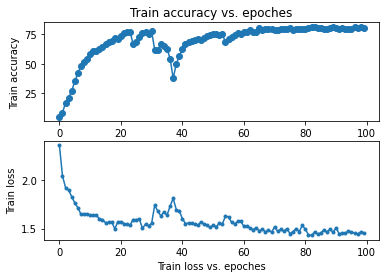

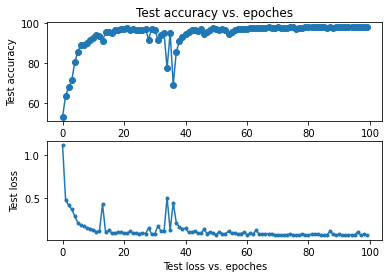

<Figure size 432x288 with 0 Axes>

In [17]:
# # Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.5)

model_ft = pre_train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

---------------Start Re-Fit-----------------


Epoch 0/119



Training Loss: 2.4704 Acc: 0.0472



Test Loss: 2.4208 Acc: 0.1138
Time from Start 3m 19s

Epoch 1/119



Training Loss: 2.2852 Acc: 0.0887



Test Loss: 2.0809 Acc: 0.2554
Time from Start 6m 39s

Epoch 2/119



Training Loss: 2.2415 Acc: 0.0745



Test Loss: 1.5881 Acc: 0.3631
Time from Start 9m 57s

Epoch 3/119



Training Loss: 2.1644 Acc: 0.1226



Test Loss: 1.2951 Acc: 0.4538
Time from Start 13m 17s

Epoch 4/119



Training Loss: 2.0757 Acc: 0.2105



Test Loss: 0.9952 Acc: 0.4892
Time from Start 16m 39s

Epoch 5/119



Training Loss: 1.9778 Acc: 0.2090



Test Loss: 0.6396 Acc: 0.6354
Time from Start 19m 57s

Epoch 6/119



Training Loss: 1.9311 Acc: 0.1552



Test Loss: 0.3802 Acc: 0.6708
Time from Start 23m 15s

Epoch 7/119



Training Loss: 1.8531 Acc: 0.1692



Test Loss: 0.3061 Acc: 0.7154
Time from Start 26m 35s

Epoch 8/119



Training Loss: 1.8165 Acc: 0.2340



Test Loss: 0.2626 Acc: 0.7492
Time from Start 29m 57s

Epoch 9/119



Training Loss: 1.8081 Acc: 0.2528



Test Loss: 0.3493 Acc: 0.7631
Time from Start 33m 16s

Epoch 10/119



Training Loss: 1.8041 Acc: 0.2726



Test Loss: 0.2645 Acc: 0.7738
Time from Start 36m 36s

Epoch 11/119



Training Loss: 1.7844 Acc: 0.3423



Test Loss: 0.2669 Acc: 0.7554

Epoch 12/119



Training Loss: 1.7659 Acc: 0.3642



Test Loss: 0.2123 Acc: 0.7908
Time from Start 43m 16s

Epoch 13/119



Training Loss: 1.7586 Acc: 0.3383



Test Loss: 0.2144 Acc: 0.7938
Time from Start 46m 35s

Epoch 14/119



Training Loss: 1.7310 Acc: 0.3653



Test Loss: 0.1854 Acc: 0.8108
Time from Start 49m 56s

Epoch 15/119



Training Loss: 1.7407 Acc: 0.4120



Test Loss: 0.1939 Acc: 0.8077

Epoch 16/119



Training Loss: 1.7279 Acc: 0.4217



Test Loss: 0.2166 Acc: 0.7954

Epoch 17/119



Training Loss: 1.7627 Acc: 0.4006



Test Loss: 0.1909 Acc: 0.8354
Time from Start 59m 54s

Epoch 18/119



Training Loss: 1.7037 Acc: 0.4082



Test Loss: 0.1813 Acc: 0.8354

Epoch 19/119



Training Loss: 1.7076 Acc: 0.4436



Test Loss: 0.1881 Acc: 0.8277

Epoch 20/119



Training Loss: 1.6689 Acc: 0.4706



Test Loss: 0.1684 Acc: 0.8523
Time from Start 69m 55s

Epoch 21/119



Training Loss: 1.6660 Acc: 0.4704



Test Loss: 0.1912 Acc: 0.8615
Time from Start 73m 14s

Epoch 22/119



Training Loss: 1.6520 Acc: 0.4955



Test Loss: 0.1430 Acc: 0.8646
Time from Start 76m 34s

Epoch 23/119



Training Loss: 1.6617 Acc: 0.4910



Test Loss: 0.1361 Acc: 0.8662
Time from Start 79m 53s

Epoch 24/119



Training Loss: 1.6373 Acc: 0.5174



Test Loss: 0.1747 Acc: 0.8708
Time from Start 83m 14s

Epoch 25/119



Training Loss: 1.6352 Acc: 0.5125



Test Loss: 0.1533 Acc: 0.8738
Time from Start 86m 34s

Epoch 26/119



Training Loss: 1.6513 Acc: 0.5173



Test Loss: 0.1364 Acc: 0.8862
Time from Start 89m 53s

Epoch 27/119



Training Loss: 1.6531 Acc: 0.5242



Test Loss: 0.1620 Acc: 0.8708

Epoch 28/119



Training Loss: 1.6525 Acc: 0.5350



Test Loss: 19318.2488 Acc: 0.0877

Epoch 29/119



Training Loss: 2.2827 Acc: 0.1848



Test Loss: 1.9779 Acc: 0.3292

Epoch 30/119



Training Loss: 2.2051 Acc: 0.1289



Test Loss: 1.6404 Acc: 0.3800

Epoch 31/119



Training Loss: 2.1578 Acc: 0.1125



Test Loss: 1.2813 Acc: 0.4954

Epoch 32/119



Training Loss: 2.0650 Acc: 0.1425



Test Loss: 0.8101 Acc: 0.5692

Epoch 33/119



Training Loss: 1.9920 Acc: 0.1640



Test Loss: 0.7240 Acc: 0.5985

Epoch 34/119



Training Loss: 1.9572 Acc: 0.1753



Test Loss: 0.5469 Acc: 0.6308

Epoch 35/119



Training Loss: 1.9415 Acc: 0.1874



Test Loss: 0.4781 Acc: 0.6769

Epoch 36/119



Training Loss: 1.9046 Acc: 0.2068



Test Loss: 0.3835 Acc: 0.6831

Epoch 37/119



Training Loss: 1.8722 Acc: 0.2292



Test Loss: 0.4029 Acc: 0.7015

Epoch 38/119



Training Loss: 1.8706 Acc: 0.2412



Test Loss: 0.3270 Acc: 0.7200

Epoch 39/119



Training Loss: 1.8550 Acc: 0.2554



Test Loss: 0.3443 Acc: 0.7231

Epoch 40/119



Training Loss: 1.8158 Acc: 0.2595



Test Loss: 0.2796 Acc: 0.7600

Epoch 41/119



Training Loss: 1.7947 Acc: 0.2884



Test Loss: 0.2758 Acc: 0.7446

Epoch 42/119



Training Loss: 1.8011 Acc: 0.2829



Test Loss: 0.2741 Acc: 0.7538

Epoch 43/119



Training Loss: 1.8042 Acc: 0.2827



Test Loss: 0.2593 Acc: 0.7585

Epoch 44/119



Training Loss: 1.7995 Acc: 0.3012



Test Loss: 0.2615 Acc: 0.7569

Epoch 45/119



Training Loss: 1.7821 Acc: 0.3123



Test Loss: 0.2484 Acc: 0.7692

Epoch 46/119



Training Loss: 1.7605 Acc: 0.3254



Test Loss: 0.2224 Acc: 0.7692

Epoch 47/119



Training Loss: 1.7842 Acc: 0.3152



Test Loss: 0.2621 Acc: 0.7708

Epoch 48/119



Training Loss: 1.7534 Acc: 0.3361



Test Loss: 0.2460 Acc: 0.7815

Epoch 49/119



Training Loss: 1.7821 Acc: 0.3317



Test Loss: 0.2249 Acc: 0.7769

Epoch 50/119



Training Loss: 1.7807 Acc: 0.3610



Test Loss: 0.2292 Acc: 0.7708

Epoch 51/119



Training Loss: 1.7536 Acc: 0.3490



Test Loss: 0.2180 Acc: 0.7877

Epoch 52/119



Training Loss: 1.7477 Acc: 0.3625



Test Loss: 0.1948 Acc: 0.7862

Epoch 53/119



Training Loss: 1.7399 Acc: 0.3568



Test Loss: 0.2361 Acc: 0.7954

Epoch 54/119



Training Loss: 1.7243 Acc: 0.3609



Test Loss: 0.2470 Acc: 0.7985

Epoch 55/119



Training Loss: 1.7490 Acc: 0.3543



Test Loss: 0.2279 Acc: 0.7954

Epoch 56/119



Training Loss: 1.7470 Acc: 0.3999



Test Loss: 0.2244 Acc: 0.7862

Epoch 57/119



Training Loss: 1.7305 Acc: 0.3769



Test Loss: 0.2067 Acc: 0.8046

Epoch 58/119



Training Loss: 1.7183 Acc: 0.4054



Test Loss: 0.2157 Acc: 0.8015

Epoch 59/119



Training Loss: 1.7068 Acc: 0.3962



Test Loss: 0.2252 Acc: 0.8062

Epoch 60/119



Training Loss: 1.7115 Acc: 0.4258



Test Loss: 0.1846 Acc: 0.8215

Epoch 61/119



Training Loss: 1.7107 Acc: 0.4201



Test Loss: 0.1895 Acc: 0.8154

Epoch 62/119



Training Loss: 1.6933 Acc: 0.4114



Test Loss: 0.1735 Acc: 0.8138

Epoch 63/119



Training Loss: 1.7001 Acc: 0.4272



Test Loss: 0.1732 Acc: 0.8308

Epoch 64/119



Training Loss: 1.7041 Acc: 0.4352



Test Loss: 0.1975 Acc: 0.8246

Epoch 65/119



Training Loss: 1.7197 Acc: 0.4158



Test Loss: 0.1983 Acc: 0.8431

Epoch 66/119



Training Loss: 1.6569 Acc: 0.4274



Test Loss: 0.1744 Acc: 0.8185

Epoch 67/119



Training Loss: 1.6847 Acc: 0.4688



Test Loss: 0.1716 Acc: 0.8323

Epoch 68/119



Training Loss: 1.6868 Acc: 0.4572



Test Loss: 0.1667 Acc: 0.8369

Epoch 69/119



Training Loss: 1.6910 Acc: 0.4265



Test Loss: 0.1527 Acc: 0.8462

Epoch 70/119



Training Loss: 1.6771 Acc: 0.4697



Test Loss: 0.1680 Acc: 0.8385

Epoch 71/119



Training Loss: 1.6593 Acc: 0.4474



Test Loss: 0.1548 Acc: 0.8462

Epoch 72/119



Training Loss: 1.6965 Acc: 0.4765



Test Loss: 0.1497 Acc: 0.8508

Epoch 73/119



Training Loss: 1.6613 Acc: 0.4710



Test Loss: 0.1748 Acc: 0.8385

Epoch 74/119



Training Loss: 1.6912 Acc: 0.4752



Test Loss: 0.1851 Acc: 0.8385

Epoch 75/119



Training Loss: 1.6588 Acc: 0.4778



Test Loss: 0.1571 Acc: 0.8385

Epoch 76/119



Training Loss: 1.6763 Acc: 0.4729



Test Loss: 0.1629 Acc: 0.8415

Epoch 77/119



Training Loss: 1.6842 Acc: 0.4725



Test Loss: 0.1812 Acc: 0.8462

Epoch 78/119



Training Loss: 1.6706 Acc: 0.4830



Test Loss: 0.1595 Acc: 0.8385

Epoch 79/119



Training Loss: 1.6923 Acc: 0.4553



Test Loss: 0.1694 Acc: 0.8354

Epoch 80/119



Training Loss: 1.6290 Acc: 0.4949



Test Loss: 0.1603 Acc: 0.8615

Epoch 81/119



Training Loss: 1.6462 Acc: 0.4967



Test Loss: 0.1543 Acc: 0.8631

Epoch 82/119



Training Loss: 1.6475 Acc: 0.4990



Test Loss: 0.1429 Acc: 0.8462

Epoch 83/119



Training Loss: 1.6636 Acc: 0.5009



Test Loss: 0.1517 Acc: 0.8523

Epoch 84/119



Training Loss: 1.6422 Acc: 0.5020



Test Loss: 0.1526 Acc: 0.8585

Epoch 85/119



Training Loss: 1.6621 Acc: 0.5084



Test Loss: 0.1504 Acc: 0.8569

Epoch 86/119



Training Loss: 1.6417 Acc: 0.4900



Test Loss: 0.1529 Acc: 0.8477

Epoch 87/119



Training Loss: 1.6463 Acc: 0.5100



Test Loss: 0.1482 Acc: 0.8692

Epoch 88/119



Training Loss: 1.6577 Acc: 0.5023



Test Loss: 0.1634 Acc: 0.8538

Epoch 89/119



Training Loss: 1.6643 Acc: 0.5134



Test Loss: 0.1611 Acc: 0.8462

Epoch 90/119



Training Loss: 1.6440 Acc: 0.5060



Test Loss: 0.1516 Acc: 0.8600

Epoch 91/119



Training Loss: 1.6330 Acc: 0.5352



Test Loss: 0.1371 Acc: 0.8723

Epoch 92/119



Training Loss: 1.6387 Acc: 0.5248



Test Loss: 0.1462 Acc: 0.8554

Epoch 93/119



Training Loss: 1.6485 Acc: 0.5202



Test Loss: 0.1581 Acc: 0.8569

Epoch 94/119



Training Loss: 1.6370 Acc: 0.5258



Test Loss: 0.1628 Acc: 0.8523

Epoch 95/119



Training Loss: 1.6196 Acc: 0.5118



Test Loss: 0.1599 Acc: 0.8692

Epoch 96/119



Training Loss: 1.6370 Acc: 0.5342



Test Loss: 0.1438 Acc: 0.8631

Epoch 97/119



Training Loss: 1.6457 Acc: 0.5176



Test Loss: 0.1365 Acc: 0.8585

Epoch 98/119



Training Loss: 1.6179 Acc: 0.5180



Test Loss: 0.1522 Acc: 0.8554

Epoch 99/119



Training Loss: 1.6574 Acc: 0.5377



Test Loss: 0.1508 Acc: 0.8692

Epoch 100/119



Training Loss: 1.6206 Acc: 0.5341



Test Loss: 0.1479 Acc: 0.8754

Epoch 101/119



Training Loss: 1.6513 Acc: 0.5271



Test Loss: 0.1508 Acc: 0.8677

Epoch 102/119



Training Loss: 1.6159 Acc: 0.5255



Test Loss: 0.1381 Acc: 0.8692

Epoch 103/119



Training Loss: 1.6342 Acc: 0.5457



Test Loss: 0.1486 Acc: 0.8754

Epoch 104/119



Training Loss: 1.6263 Acc: 0.5499



Test Loss: 0.1624 Acc: 0.8692

Epoch 105/119



Training Loss: 1.5938 Acc: 0.5462



Test Loss: 0.1520 Acc: 0.8631

Epoch 106/119



Training Loss: 1.6175 Acc: 0.5496



Test Loss: 0.1432 Acc: 0.8723

Epoch 107/119



Training Loss: 1.6402 Acc: 0.5546



Test Loss: 0.1415 Acc: 0.8754

Epoch 108/119



Training Loss: 1.6037 Acc: 0.5525



Test Loss: 0.1480 Acc: 0.8723

Epoch 109/119



Training Loss: 1.6099 Acc: 0.5517



Test Loss: 0.1399 Acc: 0.8631

Epoch 110/119



Training Loss: 1.6077 Acc: 0.5428



Test Loss: 0.1545 Acc: 0.8769

Epoch 111/119



Training Loss: 1.6183 Acc: 0.5346



Test Loss: 0.1359 Acc: 0.8723

Epoch 112/119



Training Loss: 1.6352 Acc: 0.5437



Test Loss: 0.1509 Acc: 0.8615

Epoch 113/119



Training Loss: 1.5960 Acc: 0.5465



Test Loss: 0.1546 Acc: 0.8754

Epoch 114/119



Training Loss: 1.6259 Acc: 0.5584



Test Loss: 0.1490 Acc: 0.8708

Epoch 115/119



Training Loss: 1.6247 Acc: 0.5496



Test Loss: 0.1603 Acc: 0.8662

Epoch 116/119



Training Loss: 1.5942 Acc: 0.5527



Test Loss: 0.1469 Acc: 0.8785

Epoch 117/119



Training Loss: 1.6292 Acc: 0.5630



Test Loss: 0.1383 Acc: 0.8677

Epoch 118/119



Training Loss: 1.6064 Acc: 0.5636



Test Loss: 0.1448 Acc: 0.8585

Epoch 119/119



Training Loss: 1.5865 Acc: 0.5489



Test Loss: 0.1359 Acc: 0.8708


Training complete in 398m 31s
Best train Acc: 0.563625
Best val Acc: 0.886154


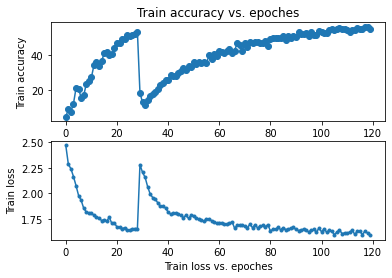

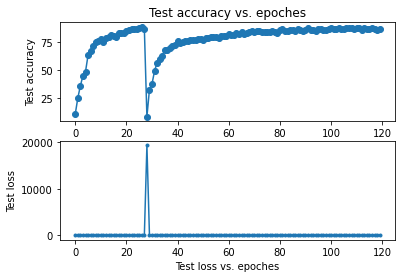

<Figure size 432x288 with 0 Axes>

In [37]:
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.5)

# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=120)
# ## M1 Model with mixup trained on SAR, 32 bs 

In [48]:
model = torch.load("28_auto_aug _eo_sar/pre_resnet34_eo_epoch89.pt")

## TTA

In [49]:
# import ttach as tta

# tta_Compose = tta.Compose(
#     [
#         tta.HorizontalFlip(),
#         tta.VerticalFlip(),
#         tta.Rotate90(angles=[0, 90, 180, 270]),      
#     ]
# )

# model = tta.ClassificationTTAWrapper(model, tta_Compose)

## Prediction

In [50]:
import pandas as pd
from torch.utils import data
from tqdm import tqdm
from PIL import Image
class ImageData(data.Dataset):
    def __init__(self,df,dirpath,transform,test = False):
        self.df = df
        self.test = test
        self.dirpath = dirpath
        self.conv_to_tensor = transform
        #image data 
        if not self.test:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
        else:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
        #labels data
        if not self.test:
             self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        img = Image.open(image_name)#.convert('RGB')
        img_tensor = self.conv_to_tensor(img)
        if not self.test:
            image_labels = self.label_df[idx]
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, int(label)] = 1
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)


In [58]:
BATCH_SIZE = 1
test_dir = "data/NTIRE2021_Class_valid_images_EO"
test_dir_ls = os.listdir(test_dir)
test_dir_ls.sort()
test_df = pd.DataFrame(test_dir_ls)

test_dataset = ImageData(test_df,test_dir,EO_data_transforms["valid_EO"],test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [59]:
output_dim = 10
output_dim

10

In [60]:
DISABLE_TQDM = False
predictions = np.zeros((len(test_dataset), output_dim))
i = 0
for test_batch in tqdm(test_loader,disable = DISABLE_TQDM):
    test_batch = test_batch.to(device)
    batch_prediction = model(test_batch).detach().cpu().numpy()
    predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    i+=1

100%|██████████| 770/770 [00:09<00:00, 79.07it/s]


In [61]:
predictions[170].sum()


-0.13973287492990494

In [62]:
predictions[169].sum()


-0.20763059705495834

In [63]:
b = predictions[170] + predictions[169]
b


array([ 1.35689402,  0.4359805 , -0.28121942, -0.19159982, -0.19006359,
       -0.14003851, -0.29969861, -0.43207946, -0.23711482, -0.36842376])

In [64]:
pred = np.argmax(predictions,axis = 1)
pred_list = []
for i in range(len(pred)):
    result = [pred[i]]
    pred_list.append(result)
pred_list

[[0],
 [0],
 [0],
 [0],
 [0],
 [9],
 [9],
 [9],
 [0],
 [8],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [3],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1],
 [0],
 [1],
 [1],
 [0],
 [1],
 [0],
 [0],
 [7],
 [8],
 [0],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [9],
 [0],
 [0],
 [0],
 [9],
 [3],
 [9],
 [0],
 [0],
 [1],
 [1],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [7],
 [9],
 [0],
 [9],
 [2],
 [7],
 [0],
 [2],
 [0],
 [0],
 [0],
 [0],
 [0],
 [7],
 [0],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [7],
 [7],
 [7],
 [0],
 [7],
 [0],
 [7],
 [0],
 [7],
 [7],
 [7],
 [7],
 [7],
 [0],
 [8],
 [7],
 [3],
 [7],
 [0],
 [7],
 [0],
 [0],
 [7],
 [3],
 [0],
 [7],
 [1],
 [0],
 [1],
 [0],
 [7],
 [7],
 [0],
 [2],
 [1],
 [7],
 [5],
 [5],
 [5],
 [0],
 [0],
 [5],
 [0],
 [0],
 [0],
 [7],
 [7],
 [7],
 [7],
 [0],
 [5],
 [7],
 [7],
 [7],
 [9],
 [7],
 [7],
 [7],
 [7],
 [0],
 [0],
 [0],
 [0],
 [1],
 [7],
 [7],
 [7]

In [65]:
predicted_class_idx = pred_list

In [66]:
test_df['class_id'] = predicted_class_idx
test_df['class_id'] = test_df['class_id'].apply(lambda x : ' '.join(map(str,list(x))))
test_df = test_df.rename(columns={0: 'image_id'})
test_df['image_id'] = test_df['image_id'].apply(lambda x : x.split('.')[0])
test_df

,image_id,class_id
0,EO_101250,0
1,EO_102512,0
2,EO_102724,0
3,EO_103079,0
4,EO_103232,0
...,...,...
765,EO_93121,0
766,EO_93871,9
767,EO_94333,0
768,EO_94927,0


In [67]:
for (idx, row) in test_df.iterrows():
    row.image_id = row.image_id.split("_")[1]

In [69]:
i = 0
for (idx, row) in test_df.iterrows():
    if row.class_id != "0":
        i+=1
print(i)

281


In [70]:
test_df

,image_id,class_id
0,101250,0
1,102512,0
2,102724,0
3,103079,0
4,103232,0
...,...,...
765,93121,0
766,93871,9
767,94333,0
768,94927,0


In [71]:
test_df.to_csv('28_auto_aug _eo_sar/results.csv',index = False)